In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random

In [2]:
epochs = 200
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 20

In [110]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [31]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

In [32]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [33]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample.npy") * 1e21

In [141]:
data_injected = np.delete(np.load("../Data_cached/4000Hz25msdatasampleBBH.npy") * 1e21, 47, axis = 0)

In [35]:
max(np.linalg.norm(data_for_training_and_testing, axis = 1))

0.42085477733884324

In [142]:
data_injected = data_injected / max(np.linalg.norm(data_injected, axis = 1))

In [143]:
max(np.linalg.norm(data_injected, axis = 1))

1.0

In [144]:
np.linalg.norm(data_injected, axis = 1).mean()

0.2795084673778969

Text(0, 0.5, 'Strain')

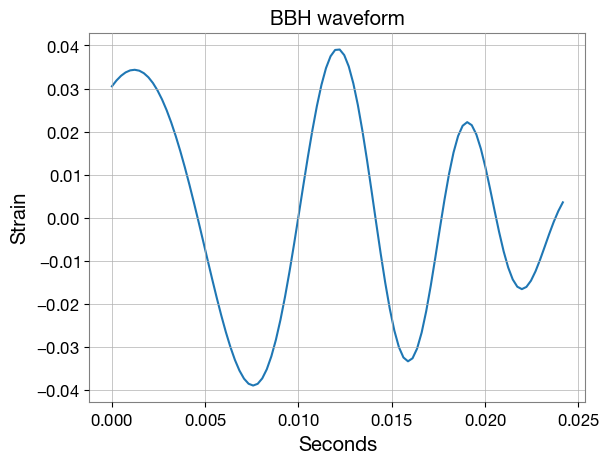

In [13]:
plt.plot(np.arange(0,100/4096, 1/4096), data_injected[0])
plt.title('BBH waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

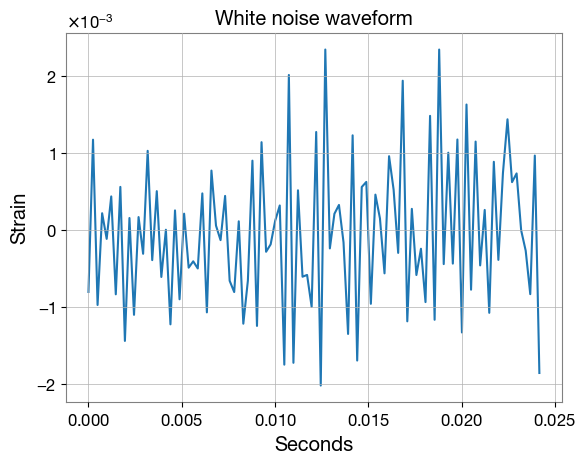

In [14]:
plt.plot(np.arange(0,100/4096, 1/4096), data_for_training_and_testing[0])
plt.title('White noise waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [112]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [151]:
np.linalg.norm(X_train_ini, axis = 1).mean()

0.3289918823749865

In [113]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [114]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected),1)))

In [13]:
X_train = np.hstack((X_train, np.ones((train_sample_number, 1))))
X_validation = np.hstack((X_validation, np.ones((validation_sample_number, 1))))
X_test = np.hstack((X_test, np.ones((test_sample_number, 1))))
data_injected_normalized = np.hstack((data_injected_normalized, np.ones((len(data_injected), 1))))

In [115]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [117]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.03075225, Validation loss=0.02680262
Epoch: 0002, Training loss=0.01717792, Validation loss=0.02039746
Epoch: 0003, Training loss=0.02145600, Validation loss=0.01993871
Epoch: 0004, Training loss=0.01733214, Validation loss=0.01865495
Epoch: 0005, Training loss=0.02285756, Validation loss=0.01784821
Epoch: 0006, Training loss=0.03418728, Validation loss=0.01733139
Epoch: 0007, Training loss=0.01548885, Validation loss=0.01653636
Epoch: 0008, Training loss=0.01532816, Validation loss=0.01577728
Epoch: 0009, Training loss=0.01362710, Validation loss=0.01466298
Epoch: 0010, Training loss=0.01296804, Validation loss=0.01398629
Epoch: 0011, Training loss=0.02577488, Validation loss=0.01292652
Epoch: 0012, Training loss=0.01114142, Validation loss=0.01206416
Epoch: 0013, Training loss=0.01045017, Validation loss=0.01095821
Epoch: 0014, Training loss=0.00953405, Validation loss=0.01013886
Epoch: 0015, Training loss=0.00921166, Validation loss=0.00957338
Epoch: 001

In [ ]:
loss_func()

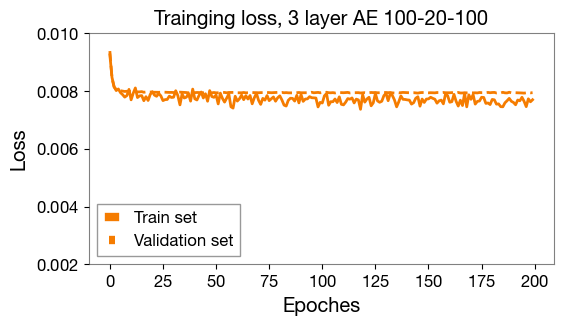

In [113]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 100-20-100')
plt.ylim(0.002,0.01)
plt.legend()
plt.show()

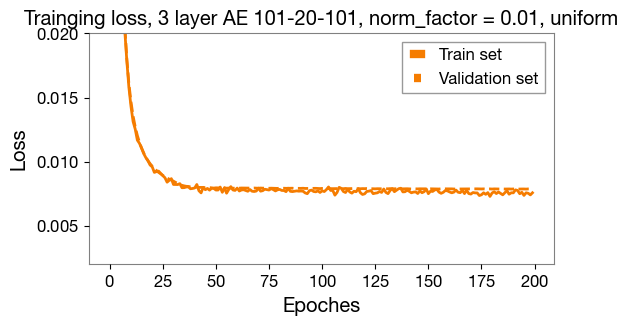

In [17]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, norm_factor = 0.01, uniform')
plt.ylim(0.002,0.02)
plt.legend()
plt.show()

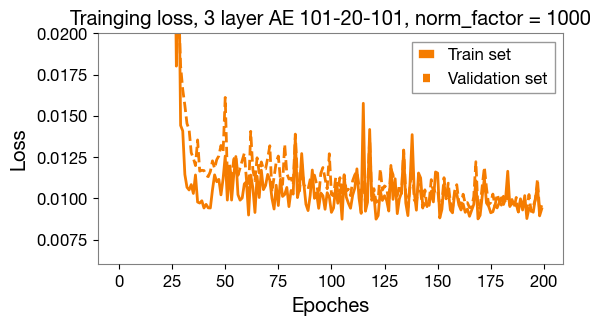

In [103]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 101-20-101, norm_factor = 1000')
plt.ylim(0.006,0.02)
plt.legend()
plt.show()

In [258]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

In [220]:
X_train_output = X_train[:, :100]
reconstructedData_train_output = reconstructedData_train[:, :100]

Text(0, 0.5, 'Strain')

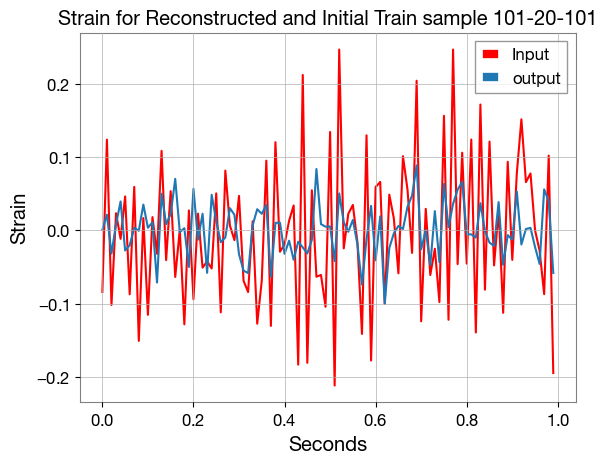

In [28]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train_output


plt.plot(x, X_train_output.flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

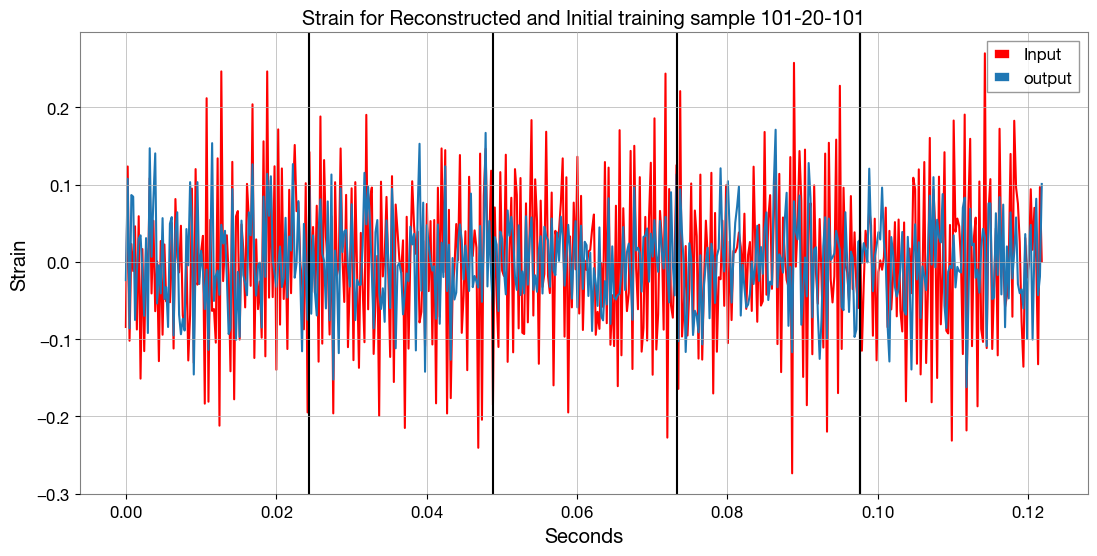

In [24]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train_output

plt.figure(figsize=(13,6))
plt.plot(x, X_train_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial training sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [120]:
ReconstructedError_train_output = np.mean((trainData.numpy()[:, :100] - reconstructedData_train[:, :100])**2, axis = 1)
MSE_train_output = ReconstructedError_train_output.mean()

In [259]:
ReconstructedError_train_output = (trainData.numpy()[:, -1] - reconstructedData_train[:, -1])**2
MSE_train_output = ReconstructedError_train_output.mean()

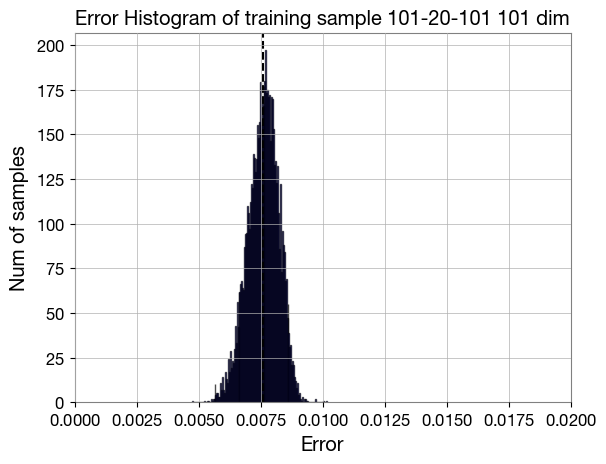

In [30]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 101-20-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

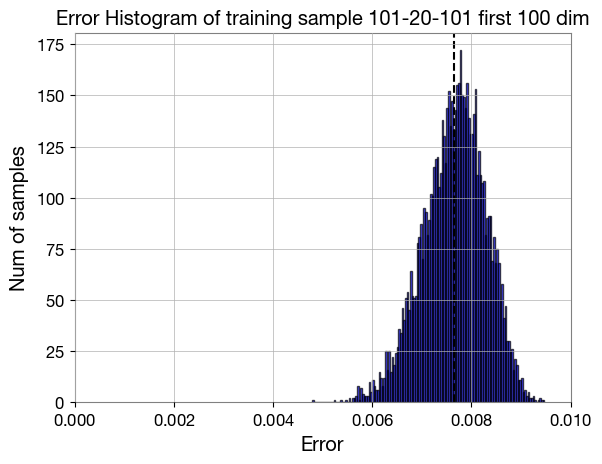

In [31]:
plt.hist(ReconstructedError_train_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 101-20-101 first 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train_output, color = 'black', linestyle = '--')
plt.show()

In [32]:
MSE_train_output

0.007648414438642514

In [260]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [122]:
X_test_output = X_test[:, :100]
reconstructedData_test_output = reconstructedData_test[:, :100]

In [248]:
ReconstructedError_test_output = np.mean((testData.numpy()[:, :100] - reconstructedData_test[:, :100])**2, axis = 1)
MSE_test_output = ReconstructedError_test_output.mean()

In [261]:
ReconstructedError_test_output = (testData.numpy()[:, -1] - reconstructedData_test[:, -1])**2
MSE_test_output = ReconstructedError_train_output.mean()

Text(0, 0.5, 'Strain')

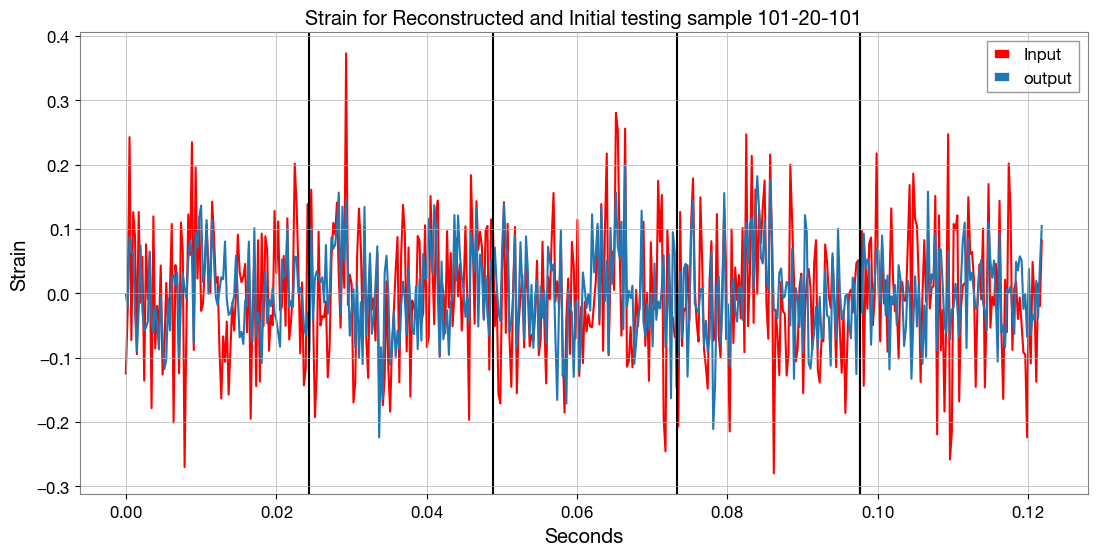

In [32]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_test_output

plt.figure(figsize=(13,6))
plt.plot(x, X_test_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial testing sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

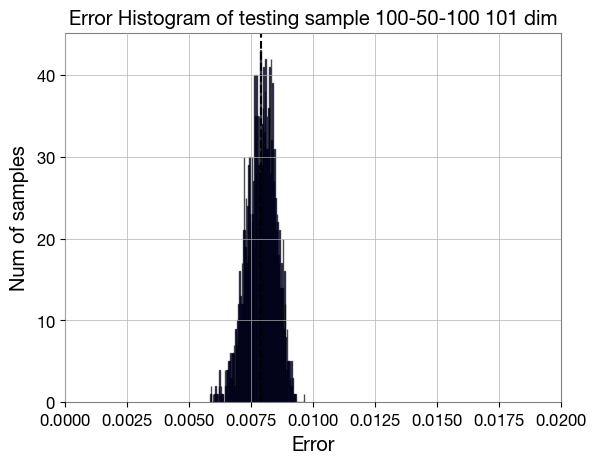

In [63]:
plt.hist(ReconstructedError_test, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample 100-50-100 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test, color = 'black', linestyle = '--')
plt.show()

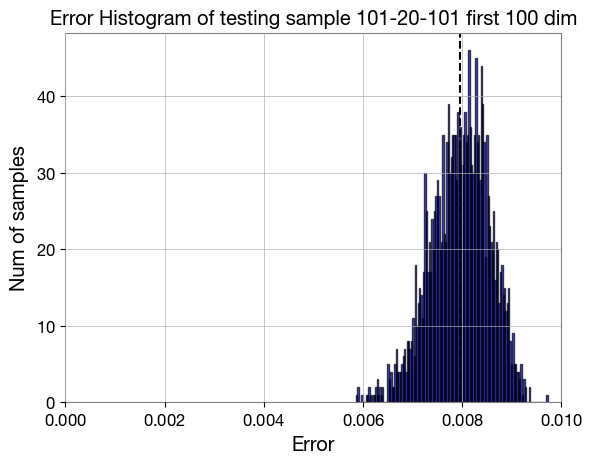

In [64]:
plt.hist(ReconstructedError_test_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample 101-20-101 first 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test_output, color = 'black', linestyle = '--')
plt.show()

In [35]:
MSE_test_output

0.008575124618823064

In [36]:
data_injected.shape

(199, 100)

In [132]:
data_injected_normalized = np.hstack((data_injected_normalized, np.ones((199, 1))))

In [262]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [166]:
ReconstructedError_injected_output = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output = ReconstructedError_injected_output.mean()

In [263]:
ReconstructedError_injected_output = (data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1])**2
MSE_injected_output = ReconstructedError_injected_output.mean()

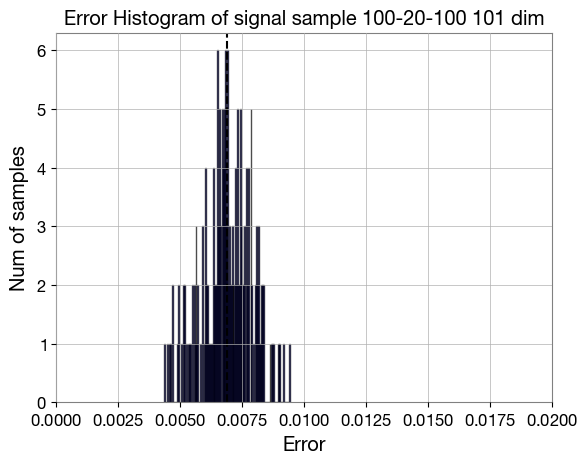

In [35]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 100-20-100 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

Text(0, 0.5, 'Strain')

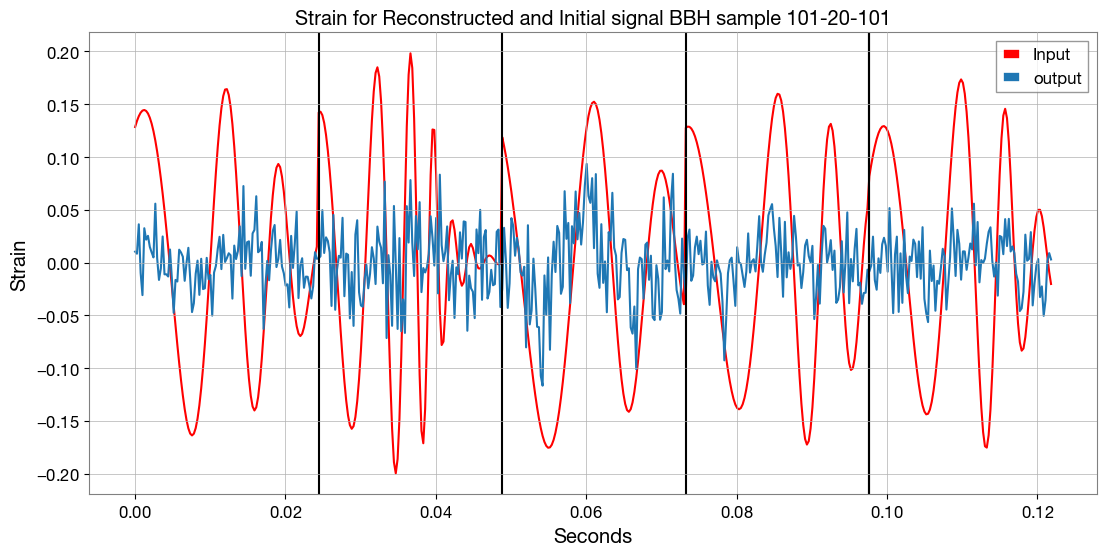

In [89]:
reconstructedData_injected_output = reconstructedData_injected[:, :100]
data_injected_normalized_output = data_injected_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_injected_output

plt.figure(figsize=(13,6))
plt.plot(x, data_injected_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial signal BBH sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

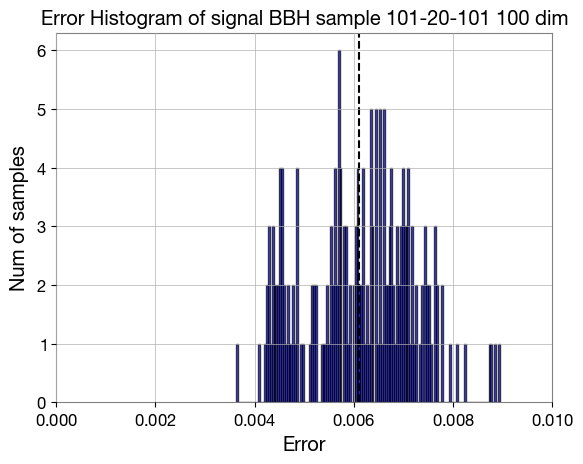

In [135]:
plt.hist(ReconstructedError_injected_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal BBH sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected_output, color = 'black', linestyle = '--')
plt.show()

In [42]:
MSE_injected_output

0.007094492407737541

In [28]:
torch.save(autoencoder, '/Volumes/Research/GWNMMAD_data/Model/101-20-101_normalized_norm_factor_10/model.pt')

In [310]:
autoencoder = torch.load('/Volumes/Research/GWNMMAD_data/Model/101-20-101_nonuniform_norm_factor_10/model.pt')

In [45]:
data_injected = np.delete(np.load("../Data_cached/4000Hz25msnoise+datasampleBBH.npy"), 47, axis = 0)
data_injected = data_injected / np.linalg.norm(data_injected)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

AttributeError: 'list' object has no attribute 'reshape'

In [46]:
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected_normalized), 1)))

In [58]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [59]:
ReconstructedError_injected_output = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output = ReconstructedError_injected_output.mean()

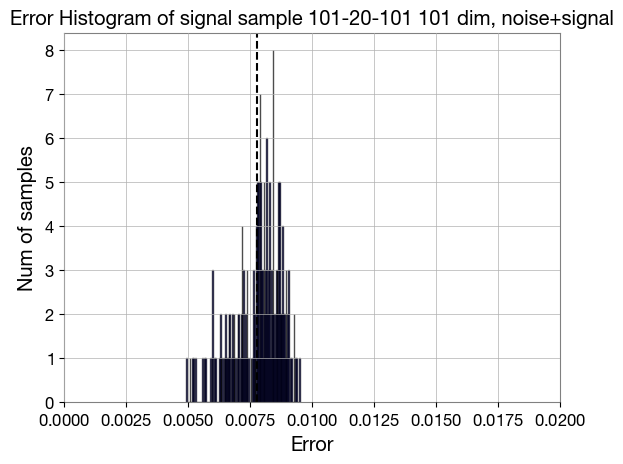

In [49]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 101-20-101 101 dim, noise+signal')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

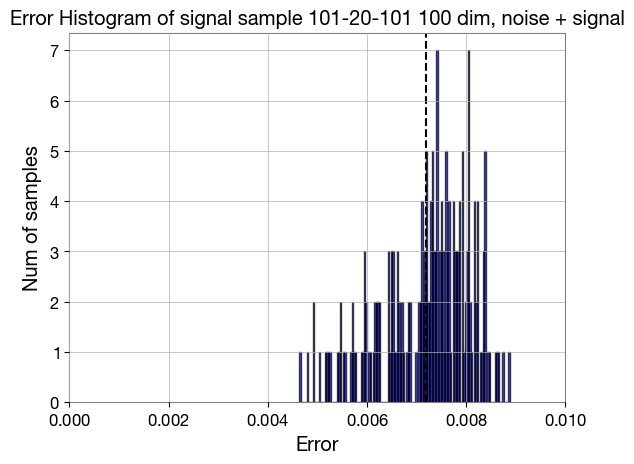

In [50]:
plt.hist(ReconstructedError_injected_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample 101-20-101 100 dim, noise + signal')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected_output, color = 'black', linestyle = '--')
plt.show()

In [168]:
data_sinegaussian = np.load('../Data_cached/sample_sg.npy')
data_sinegaussian.shape

(200, 100)

Text(0, 0.5, 'Strain')

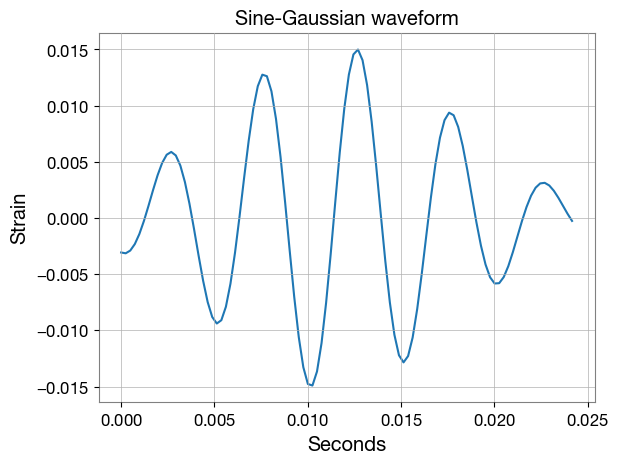

In [90]:
plt.plot(np.arange(0,100/4096, 1/4096), data_sinegaussian[14])
plt.title('Sine-Gaussian waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [149]:
max(np.linalg.norm(data_sinegaussian, axis = 1))

0.9999999999999999

In [169]:
data_sinegaussian = data_sinegaussian / max(np.linalg.norm(data_sinegaussian, axis = 1))

In [150]:
np.linalg.norm(data_sinegaussian, axis = 1).mean()

0.4961266167463434

In [170]:
data_sinegaussian_normalized, junk3, junk4 = bunch_normalization(data_sinegaussian.copy())

In [171]:
data_sinegaussian_normalized = np.hstack((data_sinegaussian_normalized, np.array(junk4).reshape(200,1)))

In [252]:
data_sinegaussian_tensored = torch.FloatTensor(data_sinegaussian_normalized)
_, decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

In [173]:
ReconstructedError_sinegaussian_output = np.mean((data_sinegaussian_tensored.numpy()[:, :100] - reconstructedData_sinegaussian[:, :100])**2, axis = 1)
MSE_sinegaussian_output = ReconstructedError_sinegaussian_output.mean()

In [253]:
ReconstructedError_sinegaussian_output = (data_sinegaussian_tensored.numpy()[:, -1] - reconstructedData_sinegaussian[:, -1])**2
MSE_sinegaussian_output = ReconstructedError_sinegaussian_output.mean()

In [201]:
MSE_sinegaussian_output

0.055473685731076916

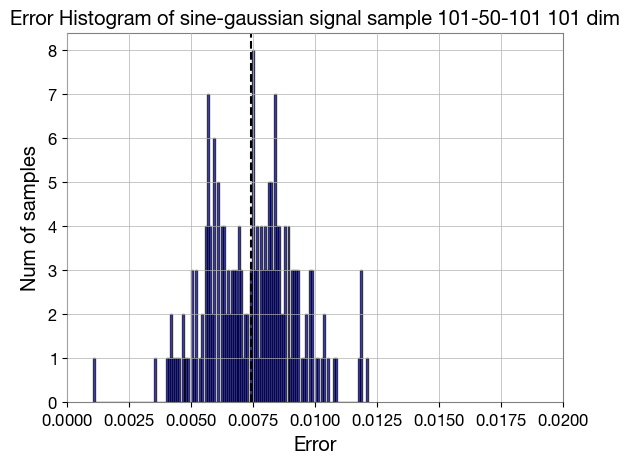

In [46]:
plt.hist(ReconstructedError_sinegaussian, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of sine-gaussian signal sample 101-50-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_sinegaussian, color = 'black', linestyle = '--')
plt.show()

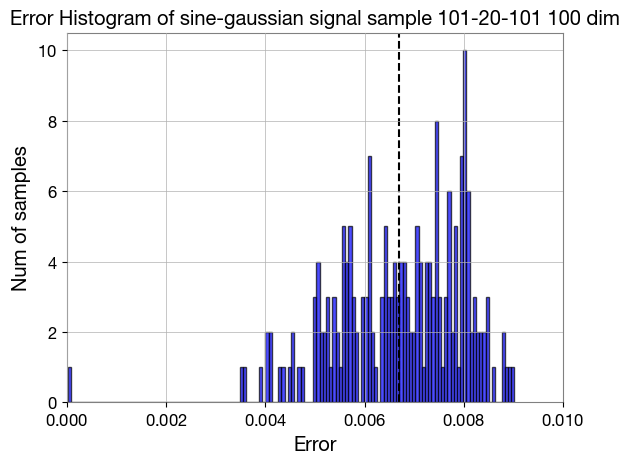

In [47]:
plt.hist(ReconstructedError_sinegaussian_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of sine-gaussian signal sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_sinegaussian_output, color = 'black', linestyle = '--')
plt.show()

In [48]:
MSE_sinegaussian_output

0.0066982354932616575

In [88]:
reconstructedData_sinegaussian_output = reconstructedData_sinegaussian[:, :100]
data_sinegaussian_normalized_output = data_sinegaussian_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_sinegaussian_output

plt.figure(figsize=(13,6))
plt.plot(x, data_sinegaussian_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial sine-gaussian sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

NameError: name 'reconstructedData_sinegaussian' is not defined

In [192]:
data_glitches= np.load('../Data_cached/sample_glitch_skewed_sinc.npy')
data_glitches.shape

(200, 100)

In [176]:
np.linalg.norm(data_glitches, axis = 1).mean()

0.03733231868591578

Text(0, 0.5, 'Strain')

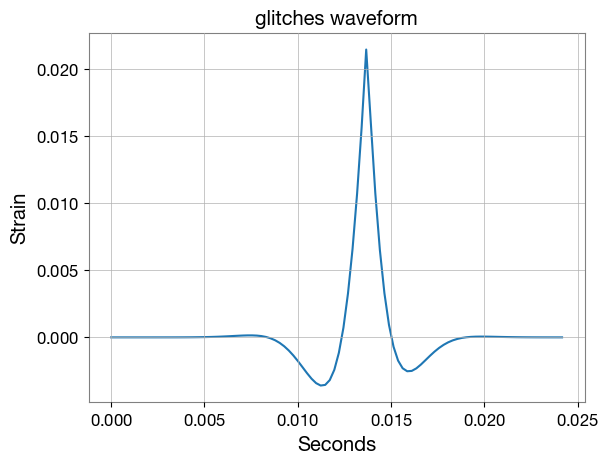

In [93]:
plt.plot(np.arange(0,100/4096, 1/4096), data_glitches[1])
plt.title('glitches waveform')
plt.xlabel('Seconds')
plt.ylabel('Strain')

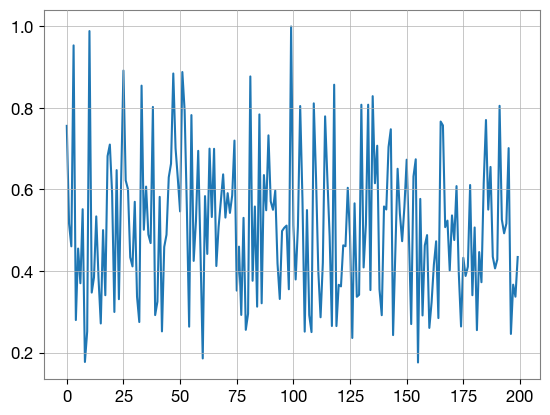

In [276]:
plt.plot(data_glitches_normalized[:,-1])

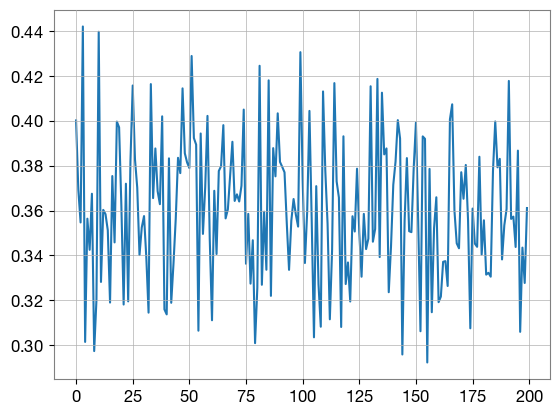

In [283]:
plt.plot(reconstructedData_glitches[:,-1])

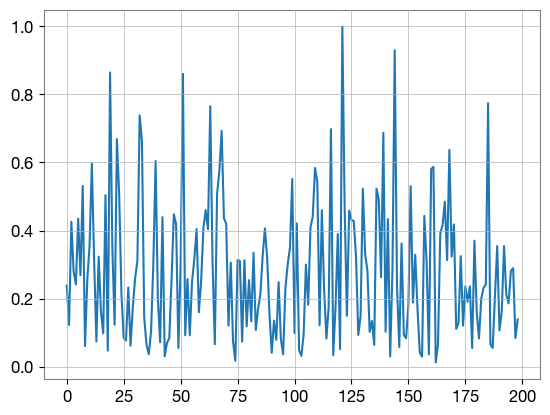

In [277]:
plt.plot(data_injected_normalized[:,-1])

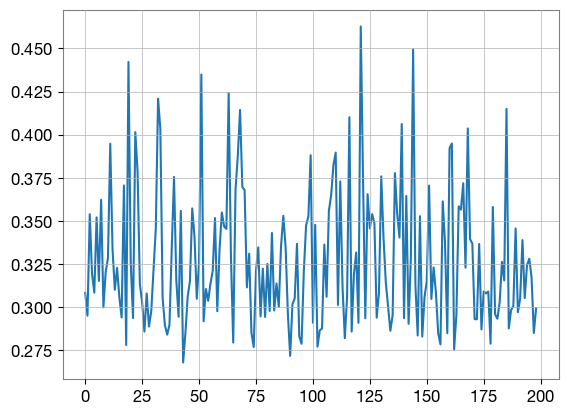

In [284]:
plt.plot(reconstructedData_injected[:,-1])

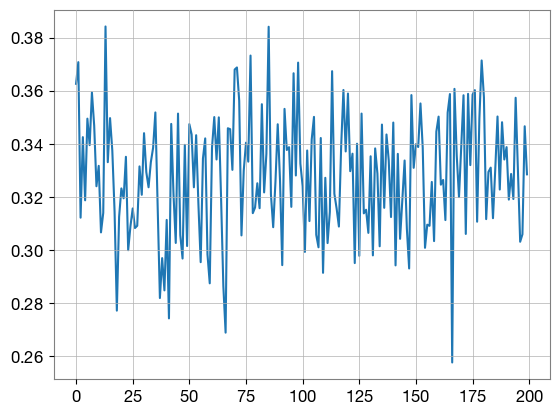

In [281]:
plt.plot(X_train[:,-1][200:400])

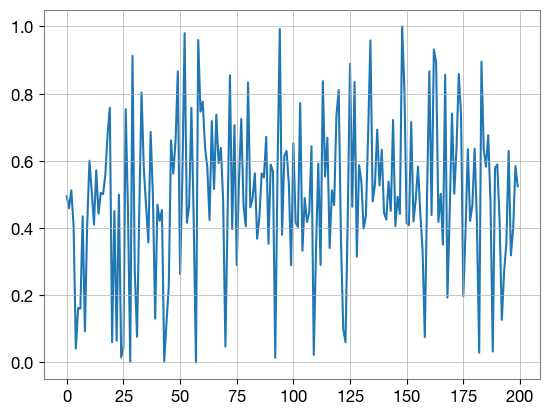

In [282]:
plt.plot(data_sinegaussian_normalized[:,-1])

In [274]:
max(np.linalg.norm(data_glitches, axis = 1))

0.9999999999999999

In [194]:
data_glitches = data_glitches / max(np.linalg.norm(data_glitches, axis = 1))

In [303]:
data_glitches_normalized, junk5, junk6 = bunch_normalization(data_glitches.copy())

In [304]:
data_glitches_normalized = np.hstack((data_glitches_normalized, np.array(junk6).reshape(200,1)-0.3 * np.ones((200,1))))

In [311]:
data_glitches_tensored = torch.FloatTensor(data_glitches_normalized)
_, decodedTestdata = autoencoder(data_glitches_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches = decodedTestdata.detach().numpy()
ReconstructedError_glitches = torch.mean((data_glitches_tensored - reconstructedData_glitches)**2,dim=1)
MSE_glitches = ReconstructedError_glitches.mean()

In [182]:
ReconstructedError_glitches_output = np.mean((data_glitches_tensored.numpy()[:, :100] - reconstructedData_glitches[:, :100])**2, axis = 1)
MSE_glitches_output = ReconstructedError_glitches_output.mean()

In [312]:
ReconstructedError_glitches_output = (data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1])**2
MSE_glitches_output = ReconstructedError_glitches_output.mean()

-0.04779369618051016

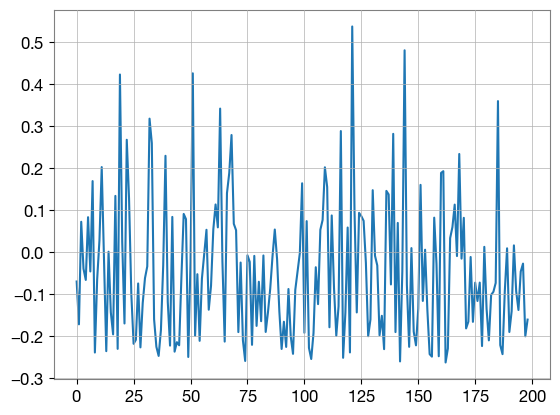

In [308]:
plt.plot((data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1]))
(data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1]).mean()

-0.004586538962321356

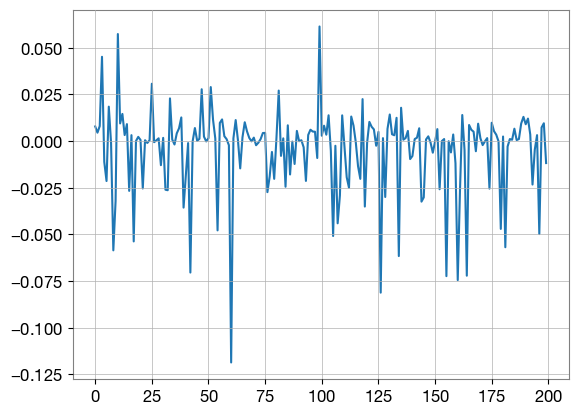

In [314]:
plt.plot((data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1]))
(data_glitches_tensored.numpy()[:, -1] - reconstructedData_glitches[:, -1]).mean()

In [272]:
ReconstructedError_glitches_output.sum()

8.880274654549748

In [307]:
MSE_glitches_output

0.03203011066039837

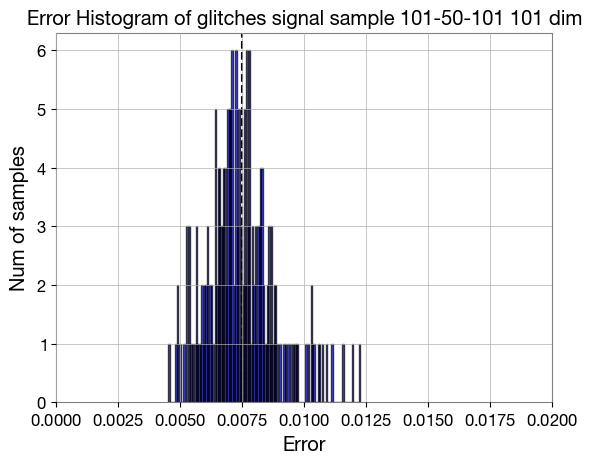

In [57]:
plt.hist(ReconstructedError_glitches, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of glitches signal sample 101-50-101 101 dim')
plt.xlim(0,0.02)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_glitches, color = 'black', linestyle = '--')
plt.show()

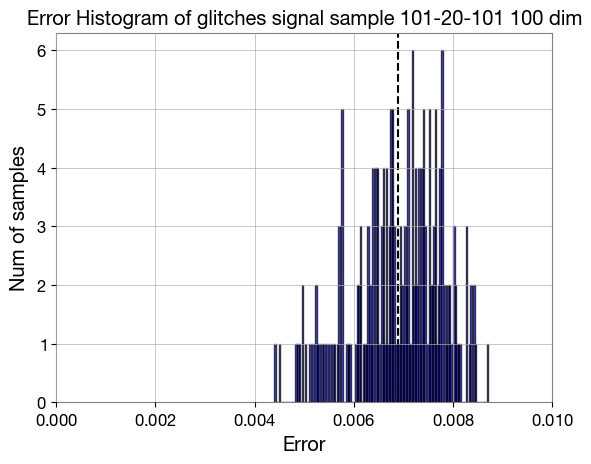

In [58]:
plt.hist(ReconstructedError_glitches_output, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of glitches signal sample 101-20-101 100 dim')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_glitches_output, color = 'black', linestyle = '--')
plt.show()

In [313]:
MSE_glitches_output

0.0005216723145263592

Text(0, 0.5, 'Strain')

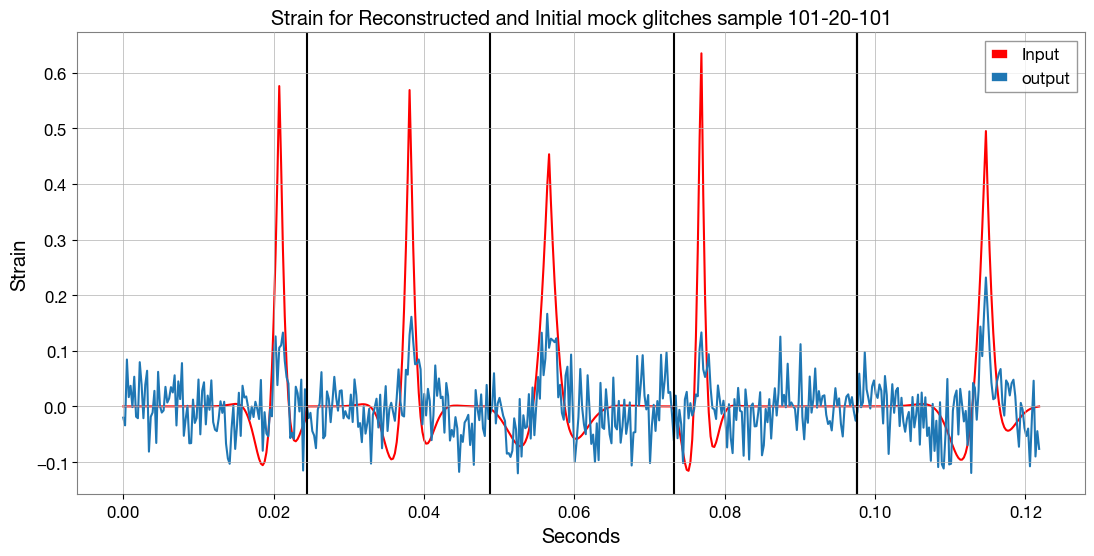

In [69]:
reconstructedData_glitches_output = reconstructedData_glitches[:, :100]
data_glitches_normalized_output = data_glitches_normalized[:, :100]
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_glitches_output

plt.figure(figsize=(13,6))
plt.plot(x, data_glitches_normalized_output.flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial mock glitches sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

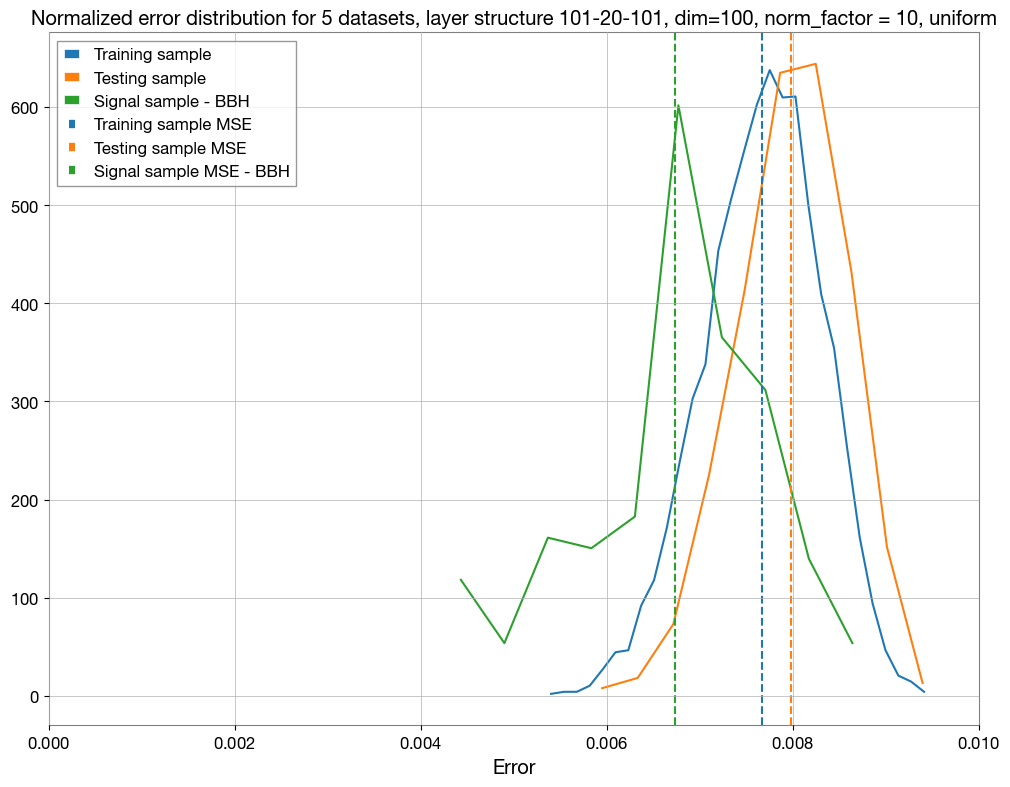

In [26]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output, bins = 10, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = 10, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = 10, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = 10, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.01)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=100, norm_factor = 10, uniform')
plt.legend()
plt.show()

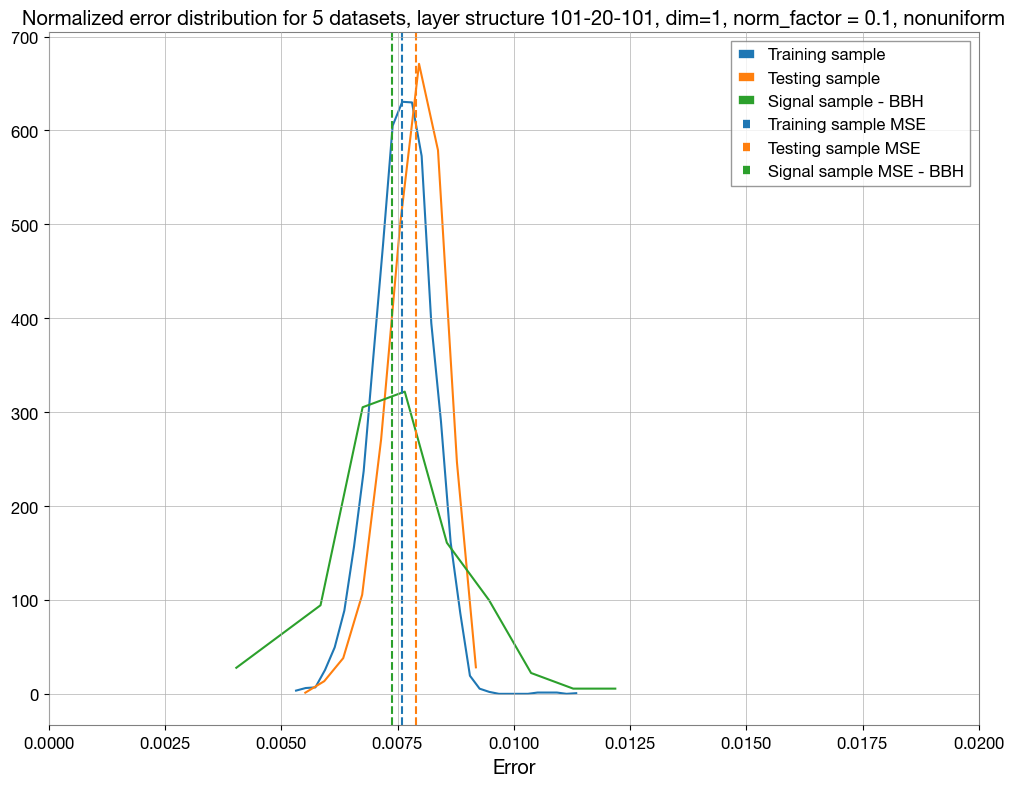

In [265]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = 10, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = 10, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = 10, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = 10, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.02)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-20-101, dim=1, norm_factor = 0.1, nonuniform')
plt.legend()
plt.show()

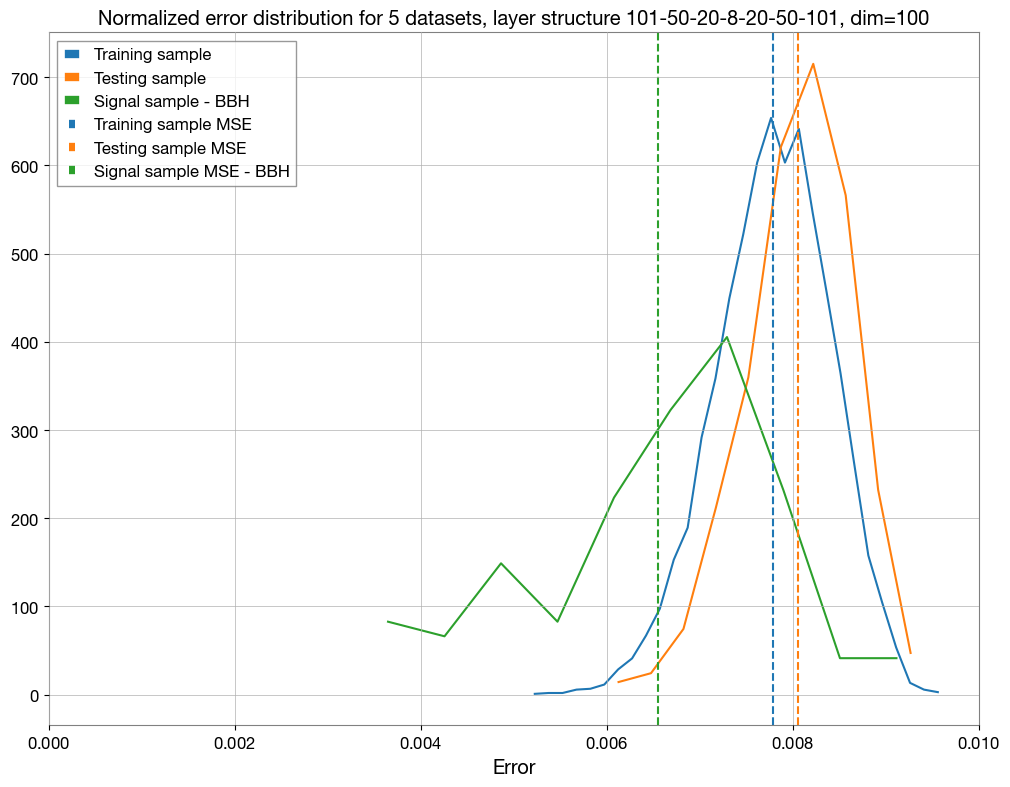

In [126]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output, bins = 30, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output, bins = 10, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output, bins = 10, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output, bins = 10, density = True)
# counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output, bins = 10, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 0.01)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 101-50-20-8-20-50-101, dim=100')
plt.legend()
plt.show()